In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
print("Загрузка MNIST...")
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist.data.values.astype('float32'), mnist.target.values.astype('int')
print(f"Данные загружены: {X.shape}, метки: {y.shape}")

Загрузка MNIST...
Данные загружены: (70000, 784), метки: (70000,)


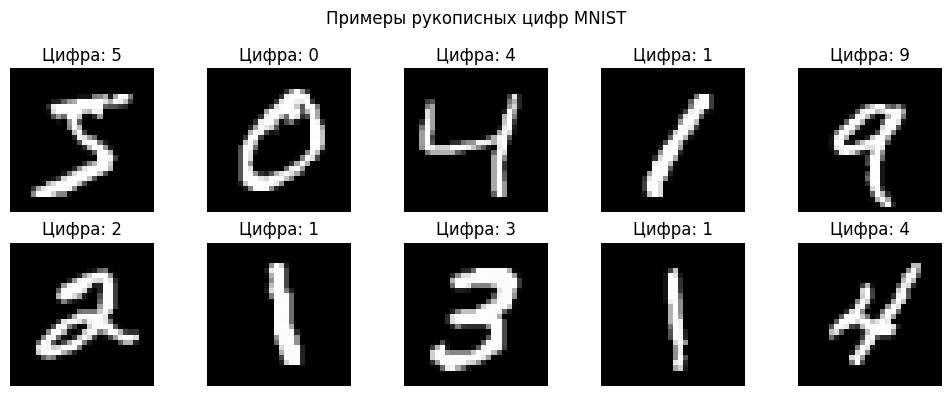

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Цифра: {y[i]}')
    ax.axis('off')
plt.suptitle('Примеры рукописных цифр MNIST')
plt.tight_layout()
plt.show()

In [4]:
class my_PCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean_ = None
        self.components_ = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        self.mean_ = X.mean(axis=0)
        X_centered = X - self.mean_
        U, s, Vt = np.linalg.svd(X_centered, full_matrices=False)
        self.components_ = Vt.T
        self.explained_variance_ratio_ = (s**2) / np.sum(s**2)
        return self

    def transform(self, X):
        X_centered = X - self.mean_
        X_transformed = X_centered @ self.components_
        if self.n_components:
            return X_transformed[:, :self.n_components]
        return X_transformed

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [5]:
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=10000, random_state=42, stratify=y)
pca_full = my_PCA()
X_pca_sample = pca_full.fit_transform(X_sample)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

In [6]:
print(f"Первые 15 компонент объясняют {cum_var[14]:.3%} дисперсии")
print(f"Для 95% дисперсии нужно {np.argmax(cum_var >= 0.95) + 1} компонент")
print(f"Для 99% дисперсии нужно {np.argmax(cum_var >= 0.99) + 1} компонент")

Первые 15 компонент объясняют 58.278% дисперсии
Для 95% дисперсии нужно 151 компонент
Для 99% дисперсии нужно 325 компонент


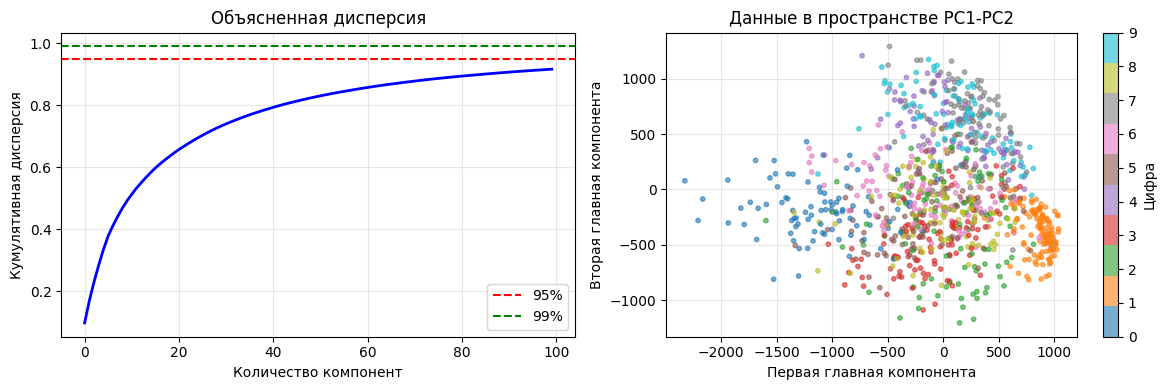

In [12]:
fig1, ax1 = plt.subplots(1, 2, figsize=(12, 4))
ax1[0].plot(cum_var[:100], 'b-', linewidth=2)
ax1[0].axhline(y=0.95, color='r', linestyle='--', label='95%')
ax1[0].axhline(y=0.99, color='g', linestyle='--', label='99%')
ax1[0].set_xlabel('Количество компонент')
ax1[0].set_ylabel('Кумулятивная дисперсия')
ax1[0].set_title('Объясненная дисперсия')
ax1[0].legend()
ax1[0].grid(True, alpha=0.3)

scatter1 = ax1[1].scatter(X_pca_sample[:1000, 0], X_pca_sample[:1000, 1],
                          c=y_sample[:1000], cmap='tab10', alpha=0.6, s=10)
ax1[1].set_xlabel('Первая главная компонента')
ax1[1].set_ylabel('Вторая главная компонента')
ax1[1].set_title('Данные в пространстве PC1-PC2')

cbar1 = fig1.colorbar(scatter1, ax=ax1[1])
cbar1.set_label('Цифра')
ax1[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
class my_kNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            distances = np.sqrt(((self.X_train - X[i])**2).sum(axis=1))
            nearest_indices = np.argsort(distances)[:self.n_neighbors]
            nearest_labels = self.y_train[nearest_indices]
            predictions.append(np.bincount(nearest_labels).argmax())
        return np.array(predictions)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y
)
print(f"\nОбучающая выборка: {X_train.shape}, Тестовая: {X_test.shape}")


Обучающая выборка: (60000, 784), Тестовая: (10000, 784)


In [15]:
print("\n1. kNN на исходных данных:")
knn_base = my_kNN(n_neighbors=5)
knn_base.fit(X_train[:5000], y_train[:5000])  # Подвыборка для скорости
test_sample_idx = np.random.choice(len(X_test), 2000, replace=False)
y_pred_base = knn_base.predict(X_test[test_sample_idx])
accuracy_base = accuracy_score(y_test[test_sample_idx], y_pred_base)
print(f"   Точность: {accuracy_base:.4f}")


1. kNN на исходных данных:
   Точность: 0.9320


In [18]:
print("\n2. Подбор параметров PCA и kNN:")
best_acc = 0
best_params = (0, 0)

n_components_list = [10, 30, 50, 100, 200]
n_neighbors_list = [3, 5, 7, 9]


2. Подбор параметров PCA и kNN:


In [24]:
for n_components in n_components_list:
    pca = my_PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train[:5000])  # Подвыборка для скорости
    X_test_pca = pca.transform(X_test[:1000])

    for n_neighbors in n_neighbors_list:
        knn = my_kNN(n_neighbors=n_neighbors)
        knn.fit(X_train_pca, y_train[:5000])
        y_pred = knn.predict(X_test_pca)
        acc = accuracy_score(y_test[:1000], y_pred)

        if acc > best_acc:
            best_acc = acc
            best_params = (n_components, n_neighbors)

        print(f"   PCA={n_components:3d}, k={n_neighbors}: accuracy={acc:.4f}")

print(f"\nЛучшие параметры: PCA={best_params[0]}, k={best_params[1]}")
print(f"Лучшая точность: {best_acc:.4f}")

   PCA= 10, k=3: accuracy=0.8900
   PCA= 10, k=5: accuracy=0.8990
   PCA= 10, k=7: accuracy=0.8920
   PCA= 10, k=9: accuracy=0.8980
   PCA= 30, k=3: accuracy=0.9550
   PCA= 30, k=5: accuracy=0.9470
   PCA= 30, k=7: accuracy=0.9500
   PCA= 30, k=9: accuracy=0.9490
   PCA= 50, k=3: accuracy=0.9540
   PCA= 50, k=5: accuracy=0.9470
   PCA= 50, k=7: accuracy=0.9410
   PCA= 50, k=9: accuracy=0.9430
   PCA=100, k=3: accuracy=0.9480
   PCA=100, k=5: accuracy=0.9410
   PCA=100, k=7: accuracy=0.9420
   PCA=100, k=9: accuracy=0.9360
   PCA=200, k=3: accuracy=0.9430
   PCA=200, k=5: accuracy=0.9390
   PCA=200, k=7: accuracy=0.9390
   PCA=200, k=9: accuracy=0.9330

Лучшие параметры: PCA=30, k=3
Лучшая точность: 0.9550


In [25]:
print("\n3. Финальная модель с лучшими параметрами:")
final_pca = my_PCA(n_components=best_params[0])
X_train_final = final_pca.fit_transform(X_train[:10000])  # Увеличиваем выборку
X_test_final = final_pca.transform(X_test)

final_knn = my_kNN(n_neighbors=best_params[1])
final_knn.fit(X_train_final, y_train[:10000])

test_idx = np.random.choice(len(X_test), 2000, replace=False)
y_pred_final = final_knn.predict(X_test_final[test_idx])
accuracy_final = accuracy_score(y_test[test_idx], y_pred_final)
print(f"   Точность финальной модели: {accuracy_final:.4f}")


3. Финальная модель с лучшими параметрами:
   Точность финальной модели: 0.9490



4. Примеры предсказаний:


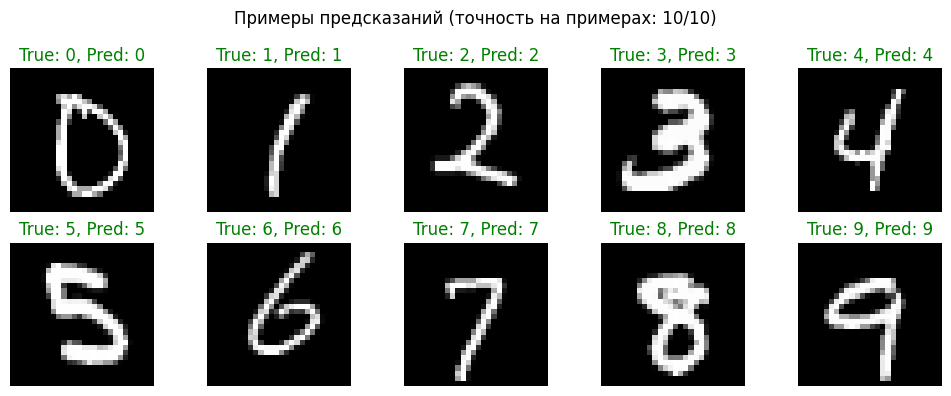

In [27]:
print("\n4. Примеры предсказаний:")
fig2, axes2 = plt.subplots(2, 5, figsize=(10, 4))
correct = 0
total = 0

for i in range(10):
    ax = axes2[i//5, i%5]
    idx = np.where(y_test == i)[0][0] if np.any(y_test == i) else 0
    ax.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    pred = final_knn.predict(X_test_final[idx:idx+1])[0]
    true = y_test[idx]

    color = 'green' if pred == true else 'red'
    ax.set_title(f'True: {true}, Pred: {pred}', color=color)
    ax.axis('off')

    if pred == true:
        correct += 1
    total += 1

plt.suptitle(f'Примеры предсказаний (точность на примерах: {correct}/{total})')
plt.tight_layout()
plt.show()


5. Визуализация зависимости точности от параметров:


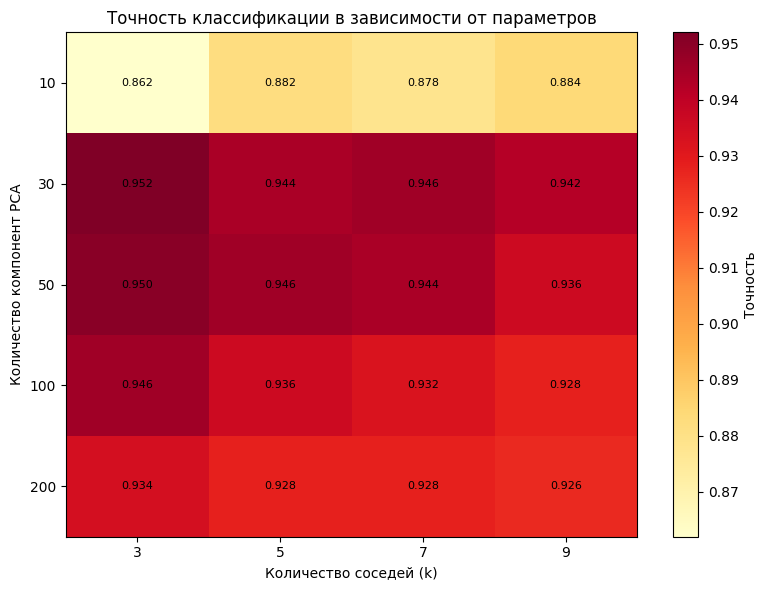

In [28]:
print("\n5. Визуализация зависимости точности от параметров:")
accuracy_grid = np.zeros((len(n_components_list), len(n_neighbors_list)))

for i, n_components in enumerate(n_components_list):
    pca = my_PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train[:3000])
    X_test_pca = pca.transform(X_test[:500])

    for j, n_neighbors in enumerate(n_neighbors_list):
        knn = my_kNN(n_neighbors=n_neighbors)
        knn.fit(X_train_pca, y_train[:3000])
        y_pred = knn.predict(X_test_pca)
        accuracy_grid[i, j] = accuracy_score(y_test[:500], y_pred)

fig3, ax3 = plt.subplots(figsize=(8, 6))
im = ax3.imshow(accuracy_grid, cmap='YlOrRd', aspect='auto')
ax3.set_xticks(range(len(n_neighbors_list)))
ax3.set_yticks(range(len(n_components_list)))
ax3.set_xticklabels(n_neighbors_list)
ax3.set_yticklabels(n_components_list)
ax3.set_xlabel('Количество соседей (k)')
ax3.set_ylabel('Количество компонент PCA')
ax3.set_title('Точность классификации в зависимости от параметров')

for i in range(len(n_components_list)):
    for j in range(len(n_neighbors_list)):
        text = ax3.text(j, i, f'{accuracy_grid[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=8)

cbar3 = fig3.colorbar(im, ax=ax3)
cbar3.set_label('Точность')
plt.tight_layout()
plt.show()